# Image Preprocessing for quantitative discrimination of dried blood droplets

An example notebook, trying to reproduce the preprocessing steps as presented in [Machine Learning Analysis for
Quantitative Discrimination of
Dried Blood Droplets](https://www.nature.com/articles/s41598-020-59847-x.pdf)

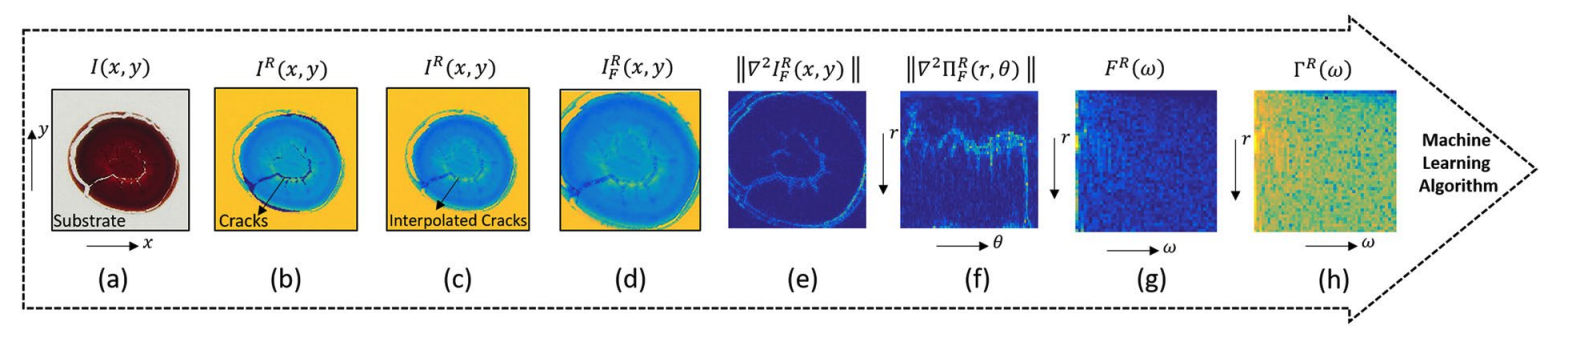

This process requires (b) crack detection (c) crack interpolation (d) Gaussian blur (e) edge detection (f) transformation to polar coordinates (g) computation of 1d power spectrum via Fourier transform and (h) the logarithmic power spectrum.

The processed images are then averaged across test person and condition and finally passed on to train an unsupervised learning method consisting of Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA).

In [ ]:
from pathlib import Path
from PIL import Image, ImageOps, ImageFilter
from ipywidgets.widgets import HBox, Output
from IPython.display import display
import numpy as np
import cv2
from scipy.interpolate import griddata
from matplotlib import pyplot as plt

## Example image

For testing the pipeline we are using the below image for trial person 1 after 2 mins image 6

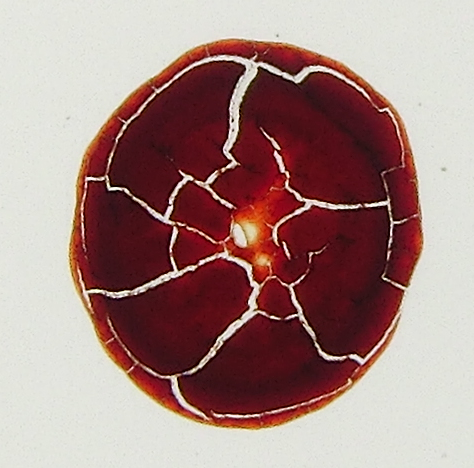

In [ ]:
path = Path('./data/person_1_after2_6.tif')
img = Image.open(path)
img

### Crack detection

As described in the paper cracks are detected using a simple treshold criteria:  $I^R(x,y)[I^{G,B}(x,y)>\alpha]$.
Translated: the cracks are in regions in the red channel ($R$) where intensity ($I$)  values in the green ($G$) and blue ($B$) channel are above a certain treshhold $\alpha$.

To get smoother mask of the cell, we are using OpenCVs findContours method and assume that the largest contour belongs to the cell. We also calculate the center and radius of the enclosing circle to later be used for the transformation into polar coordinates.

In [ ]:
def image_output(img, color='black'):
    img = ImageOps.colorize(img, black='black', white=color)
    out = Output()
    with out:

        display(img)
    return out
red, green, blue = img.split()
HBox([image_output(red, 'Salmon'), image_output(green, 'LightGreen'), image_output(blue, 'SlateBlue')])

In [ ]:
RED_TRESH = 150

def find_cell(img):
    """Creates a binary mask of the cell with 0=not cell and 1=cell."""
    # turn into binary for findContours using simple treshholding >RED_TRESH
    binary = np.ones_like(img)
    binary[np.array(img)>RED_TRESH] = 0
    #  find hull of cell for a smooth mask   
    contours, _ = cv2.findContours(np.array(binary), cv2.cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours.sort(key=lambda c: cv2.contourArea(c), reverse=True)
    hull = cv2.convexHull(contours[0])
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [hull], 0, (1), cv2.FILLED)
    # Calculate center and radius for transformation to polar coordinates
    center,radius = cv2.minEnclosingCircle(contours[0])
    return mask, center, radius


ALPHA = 100

def detect_cracks(cell, green, blue):
    mask = np.zeros_like(green)
    mask[(cell>0)& (np.array(blue)>ALPHA) & (np.array(green)>ALPHA)] = 1
    return mask

cell, center, max_radius = find_cell(red)
mask = detect_cracks(cell, green,blue)

### Show cracks

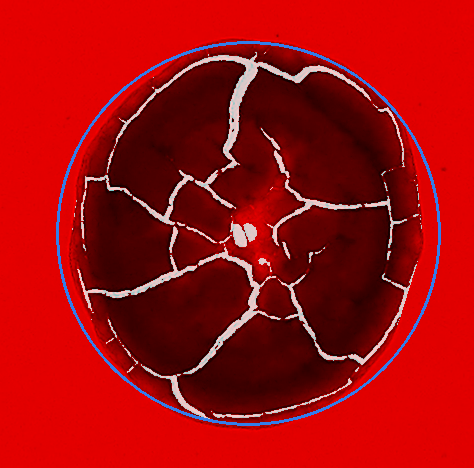

In [ ]:
Image.fromarray(cv2.circle(np.dstack((np.array(red), 200*mask, 200*mask)), tuple(int(x) for x in center)
        , int(max_radius)
        , (50,125,235)
        , 2
    )
)       

## Crack interpolation

We use the created mask of cracks from above and interpolate them using [`griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) from scipy. The _linear_ and _cubic_ method result in black line on lower edge so we are using _nearest_. _Nearest_ returns the value of the data point closest to the interpolated point.

In [ ]:
red_arr = np.array(red)
ny, nx = red_arr.shape
grid_x, grid_y = np.mgrid[0:nx, 0:ny]
points = np.argwhere(mask<1)
values = red_arr[mask<1]
points.shape, values.shape

((212395, 2), (212395,))

In [ ]:
interpolated_img = griddata( points, values, (grid_x, grid_y), method='nearest')

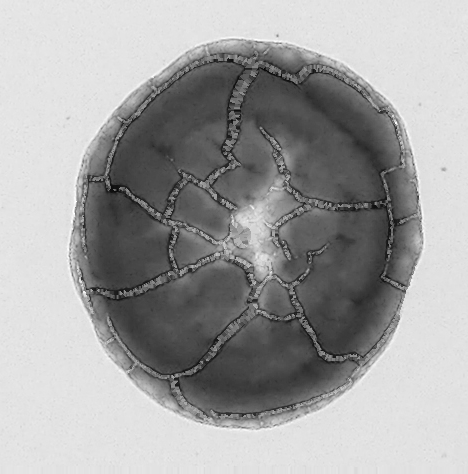

In [ ]:
Image.fromarray(interpolated_img.astype(np.uint8))

## Gaussian blur

To remove high frequency components and smoothen out quick intensity chances, we use a Gaussian blur.

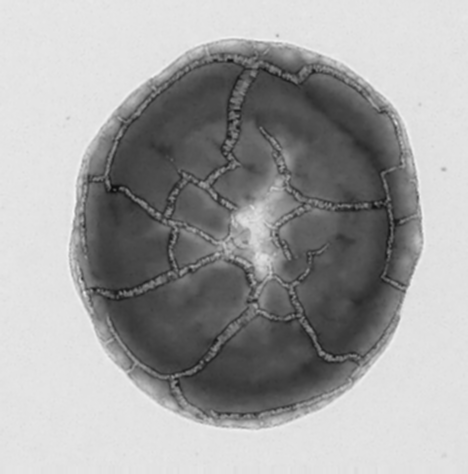

In [ ]:
blur = cv2.GaussianBlur(interpolated_img,(3,3),1)
Image.fromarray(blur)

## Edge detection

We are using `opencv`s Laplacian function for edge detection. The second spatial derivative $\nabla^2I_F^R(x,y)$ amplifies changes in pixel intensity and thus reveals edges.

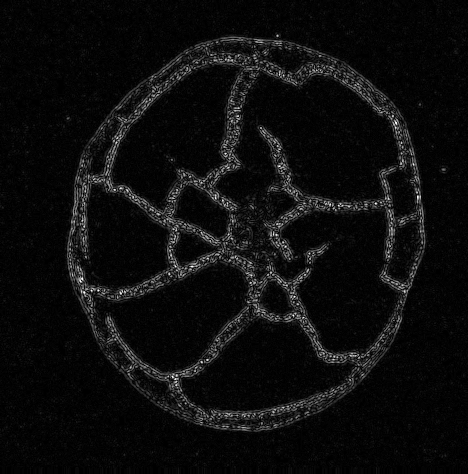

In [ ]:
lapl = cv2.Laplacian(blur, cv2.CV_16S, ksize=3)
# Convert to int8 for display
edge = cv2.convertScaleAbs(lapl)
Image.fromarray(edge)

## Polar coordinates

To calculate an angle independent power spectrum we need to transform the edge image $\|{\nabla^2I_F^R(x,y)}\|$  from cartesian coordinates to polar coordinates   $\|{\nabla^2I_F^R(r,\rho)}\|$.

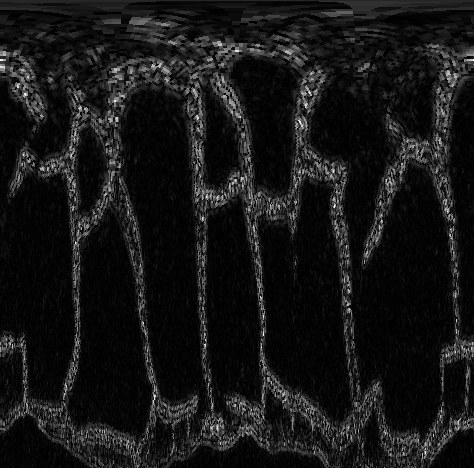

In [ ]:
polar_image = cv2.linearPolar(np.abs(lapl),center, max_radius, cv2.WARP_FILL_OUTLIERS).T

Image.fromarray(polar_image.astype(np.uint8))

## Power spectrum

In the final preprocessing step we want to calculate the logarithmic power spectrum over the angular component of the logarithmic, polar image. 

$$
\Gamma^R(r, \omega) = log \left|\int_{-\infty}^\infty e^{-i\omega\rho} log \|\nabla^2I_F^R(r,\rho)\| d\rho \right|
$$


### Open questions

In theory, this should be straight-forward we can use numpys Fast-Fourier Transform methods to calculate the frequencies across one axis. Unfortunately, our previous steps produce pixels of 0 intensity leading to $\infty$ values when calculating the logarithm.

Additionally, in the paper itself, the authors arrive at an image with 48 rows of the radial component and 103 columns for the frequency component. That indicates that they might have done some binning as described in [this blog post](https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/).

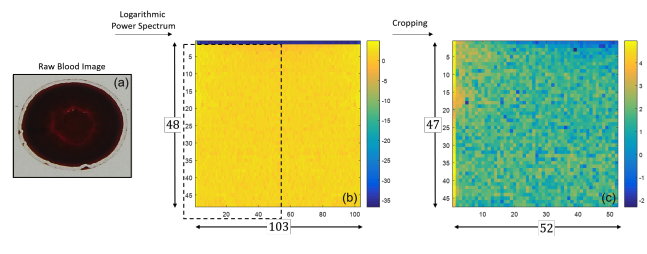

I still need to figure out how to do that and then we should be good to go for the next step 🎉

In [ ]:
axis = 1
n_rho = polar_image.shape[axis]
log = np.log(polar_image+1) 
fft = np.fft.fft2(log, axes=(axis,))
kfreq = np.fft.fftfreq(n_rho) * n_rho

In [ ]:
kbins = np.arange(0.5, 501., 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])

<ipython-input-56-f2ab1fda311b>:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(cv2.convertScaleAbs(np.log(absolute)), aspect='auto')


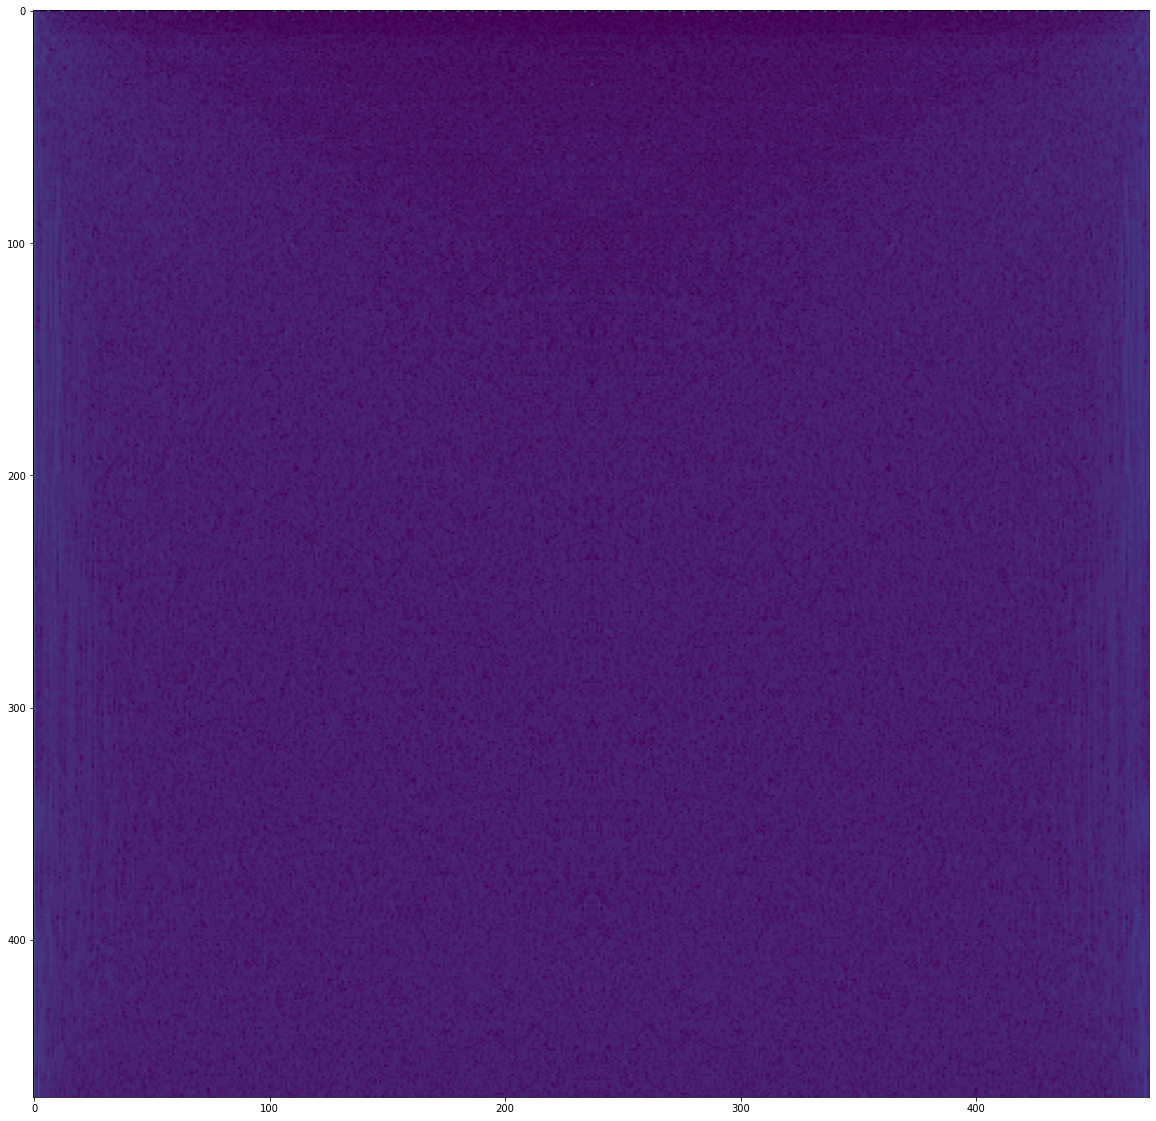

In [ ]:
plt.figure(figsize = (20,20))
absolute = np.abs(fft)
plt.imshow(cv2.convertScaleAbs(np.log(absolute)), aspect='auto')